# Imports

In [1]:
from configuration.paths import *

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import models, layers

from src.datasets.pneumonia_detection_challenge import PneumoniaDetectionChallenge
from src.utils.schemes import Scheme

# Dataset loading for training

In [2]:
IMAGE_SIZE = (256, 256)

In [3]:
pdc = PneumoniaDetectionChallenge(DATASET_PNEUMONIA_DETECTION_CHALLENGE_PATH, IMAGE_SIZE)
x_train, y_train, _ = pdc.load_train_data()
x_train = x_train / 255.0

x_val, y_val, _ = pdc.load_val_data()
x_val = x_val / 255.0

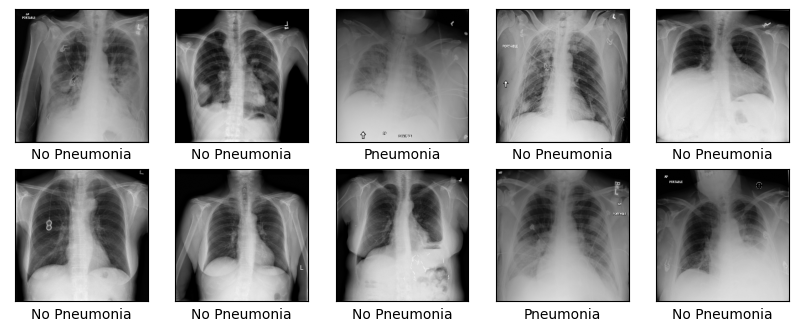

In [4]:
Scheme.labelled_images(x_train, y_train)

# Mdel definition

In [5]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16, activation='relu', kernel_size=3, padding='same', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)))
model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

model.add(layers.Conv2D(filters=32, activation="relu", kernel_size=3, padding="same"))
model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

model.add(layers.Conv2D(filters=64, activation="relu", kernel_size=3, padding="same"))
model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

model.add(layers.Conv2D(filters=128, activation="relu", kernel_size=3, padding="same"))
model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

model.add(layers.Conv2D(filters=128, activation="relu", kernel_size=3, padding="same"))
model.add(layers.MaxPool2D(pool_size=2, strides=2, padding='valid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       7

In [6]:
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       7

In [7]:
model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['binary_accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')])

# Model training

In [8]:
history = model.fit(x=x_train,
                    y=y_train,
                    validation_data=(x_val, y_val),
                    epochs=35)

Epoch 1/35
626/626 [==============================] - 33s 31ms/step - loss: 0.5011 - binary_accuracy: 0.7718 - precision: 0.4685 - recall: 0.0640 - val_loss: 0.3188 - val_binary_accuracy: 0.8000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/35
626/626 [==============================] - 16s 25ms/step - loss: 0.4382 - binary_accuracy: 0.7981 - precision: 0.6200 - recall: 0.2456 - val_loss: 0.3141 - val_binary_accuracy: 0.8500 - val_precision: 1.0000 - val_recall: 0.2500
Epoch 3/35
626/626 [==============================] - 16s 25ms/step - loss: 0.4341 - binary_accuracy: 0.7975 - precision: 0.5998 - recall: 0.2733 - val_loss: 0.2906 - val_binary_accuracy: 0.9000 - val_precision: 1.0000 - val_recall: 0.5000
Epoch 4/35
626/626 [==============================] - 16s 26ms/step - loss: 0.4390 - binary_accuracy: 0.7921 - precision: 0.6140 - recall: 0.3253 - val_loss: 0.2994 - val_binary_accuracy: 0.9000 - val_precision: 1.0000 - val_recall: 0.5000
Epoch 5/35
626/626 [============

<Figure size 640x480 with 0 Axes>

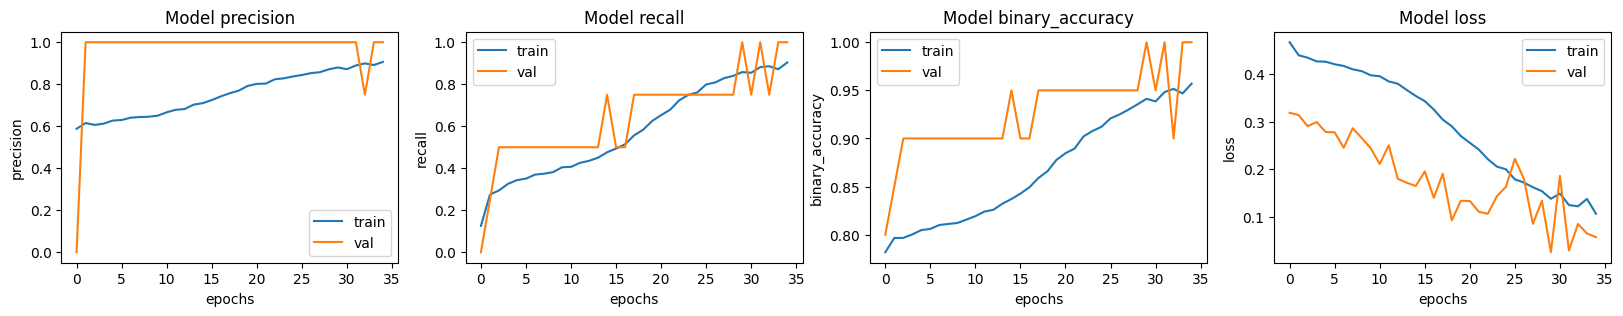

In [9]:
Scheme.training_graphs(history)

In [10]:
del x_train
del y_train

# Evaluating the model

In [11]:
x_test, y_test, images = pdc.load_test_data()
x_test = x_test / 255.0

100%|██████████| 1000/1000 [00:07<00:00, 134.13it/s]


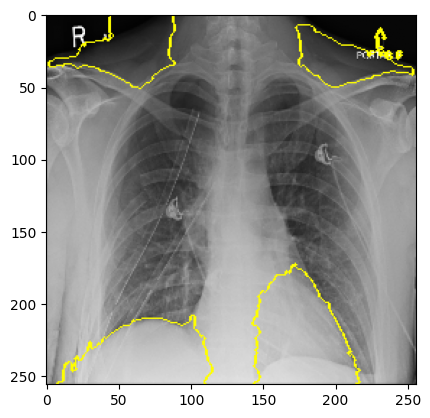

In [12]:
Scheme.explainer(x_test[80], model, IMAGE_SIZE)

In [13]:
test_loss, test_accuracy, _, _ = model.evaluate(x_test, y_test)

209/209 [==============================] - 3s 12ms/step - loss: 1.3910 - binary_accuracy: 0.7692 - precision: 0.4778 - recall: 0.4675


In [14]:
predictions = model.predict(x_test)
predictions_rounded = np.round(predictions).astype(int)

<Figure size 640x480 with 0 Axes>

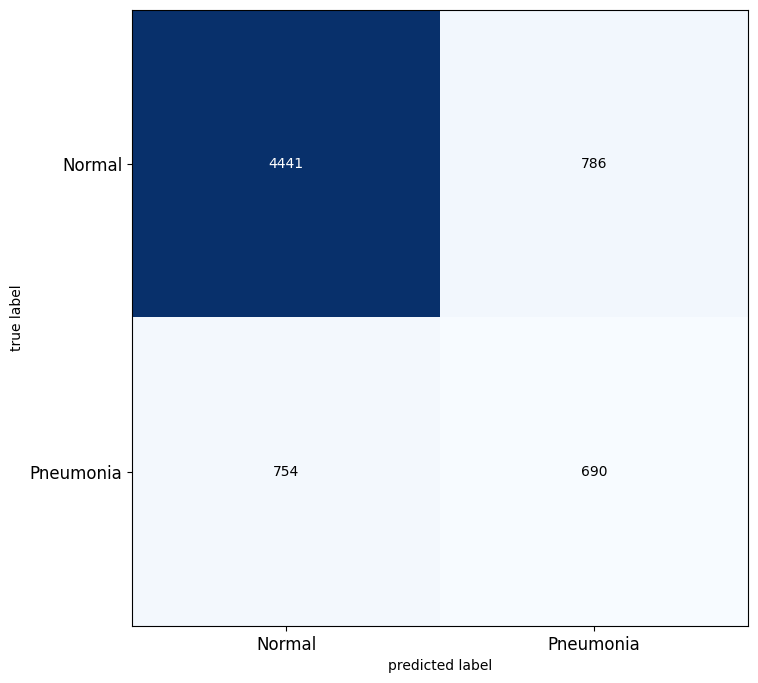

In [15]:
Scheme.confusion_matrix(predictions_rounded, pdc.get_test_df().diagnosis.to_numpy())